# 4.1 word2vec 개선  ①

In [1]:
import numpy as np
W = np.arange(21).reshape(7,3)
W

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11],
       [12, 13, 14],
       [15, 16, 17],
       [18, 19, 20]])

In [2]:
W[2]

array([6, 7, 8])

In [3]:
W[5]

array([15, 16, 17])

In [4]:
idx = [1,0,3,0]

W[idx]

array([[ 3,  4,  5],
       [ 0,  1,  2],
       [ 9, 10, 11],
       [ 0,  1,  2]])

In [5]:
class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None
        
    def forward(self,idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out
    
    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        
        # for i, word_id in enumerate(self.idx):
        # dW[word_id] += dout[i]
        np.add.at(dW, self.idx, dout)
            
        return None

# 4.2 word2vec 개선 ②

In [6]:
class EmbeddingDot:
    def __init__(self, W):
        self.embed = Embedding(W)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None

    def forward(self, h, idx):
        target_W = self.embed.forward(idx)
        out = np.sum(target_W * h, axis=1)

        self.cache = (h, target_W)
        return out

    def backward(self, dout):
        h, target_W = self.cache
        dout = dout.reshape(dout.shape[0], 1)

        dtarget_W = dout * h
        self.embed.backward(dtarget_W)
        dh = dout * target_W
        return dh

In [7]:
np.random.choice(10)

3

In [8]:
words = ['you', 'say', 'goodbye', 'I', 'hello', '.']
np.random.choice(words)

'goodbye'

In [9]:
np.random.choice(words, size = 5)

array(['.', 'say', 'I', 'hello', 'you'], dtype='<U7')

In [10]:
np.random.choice(words, size = 5, replace =False)

array(['say', 'hello', 'I', 'you', '.'], dtype='<U7')

In [11]:
p = [0.5, 0.1, 0.05, 0.2, 0.05, 0.1]
np.random.choice(words, p=p)

'you'

In [12]:
p = [0.7, 0.29, 0.01]
new_p = np.power(p, 0.75)
new_p /= np.sum(new_p)
print(new_p)

[0.64196878 0.33150408 0.02652714]


In [13]:
import collections
class UnigramSampler:
    def __init__(self, corpus, power, sample_size):
        self.sample_size = sample_size
        self.vocab_size = None
        self.word_p = None

        counts = collections.Counter()
        for word_id in corpus:
            counts[word_id] += 1

        vocab_size = len(counts)
        self.vocab_size = vocab_size

        self.word_p = np.zeros(vocab_size)
        for i in range(vocab_size):
            self.word_p[i] = counts[i]

        self.word_p = np.power(self.word_p, power)
        self.word_p /= np.sum(self.word_p)

    def get_negative_sample(self, target):
        batch_size = target.shape[0]

        
        negative_sample = np.zeros((batch_size, self.sample_size), dtype=np.int32)

        for i in range(batch_size):
            p = self.word_p.copy()
            target_idx = target[i]
            p[target_idx] = 0
            p /= p.sum()
            negative_sample[i, :] = np.random.choice(self.vocab_size, size=self.sample_size, replace=False, p=p)
        

        return negative_sample

In [14]:
corpus = np.array([0,1,2,3,4,1,2,3])
power = 0.75
sample_size = 2

sampler = UnigramSampler(corpus, power, sample_size)
target = np.array([1, 3, 0])
negative_sample = sampler.get_negative_sample(target)
print(negative_sample)

[[0 4]
 [4 0]
 [3 2]]


In [15]:
class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        self.sample_size = sample_size
        self.sampler = UnigramSampler(corpus, power, sample_size)
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)]
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]

        self.params, self.grads = [], []
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, h, target):
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_negative_sample(target)

        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32)
        loss = self.loss_layers[0].forward(score, correct_label)

        negative_label = np.zeros(batch_size, dtype=np.int32)
        for i in range(self.sample_size):
            negative_target = negative_sample[:, i]
            score = self.embed_dot_layers[1 + i].forward(h, negative_target)
            loss += self.loss_layers[1 + i].forward(score, negative_label)

        return loss

    def backward(self, dout=1):
        dh = 0
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)

        return dh

# 4.3 개선판 word2vec 학습

In [16]:
class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size

        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')

        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)  
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)

        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1 / len(self.in_layers)
        loss = self.ns_loss.forward(h, target)
        return loss

    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None

| epoch 1 |  iter 1 / 9295 | time 0[s] | loss 4.16
| epoch 1 |  iter 21 / 9295 | time 2[s] | loss 4.16
| epoch 1 |  iter 41 / 9295 | time 4[s] | loss 4.15
| epoch 1 |  iter 61 / 9295 | time 6[s] | loss 4.12
| epoch 1 |  iter 81 / 9295 | time 8[s] | loss 4.04
| epoch 1 |  iter 101 / 9295 | time 12[s] | loss 3.92
| epoch 1 |  iter 121 / 9295 | time 15[s] | loss 3.78
| epoch 1 |  iter 141 / 9295 | time 18[s] | loss 3.62
| epoch 1 |  iter 161 / 9295 | time 22[s] | loss 3.47
| epoch 1 |  iter 181 / 9295 | time 25[s] | loss 3.34
| epoch 1 |  iter 201 / 9295 | time 29[s] | loss 3.24
| epoch 1 |  iter 221 / 9295 | time 32[s] | loss 3.14
| epoch 1 |  iter 241 / 9295 | time 35[s] | loss 3.09
| epoch 1 |  iter 261 / 9295 | time 38[s] | loss 3.00
| epoch 1 |  iter 281 / 9295 | time 42[s] | loss 2.97
| epoch 1 |  iter 301 / 9295 | time 45[s] | loss 2.92
| epoch 1 |  iter 321 / 9295 | time 48[s] | loss 2.86
| epoch 1 |  iter 341 / 9295 | time 51[s] | loss 2.84
| epoch 1 |  iter 361 / 9295 | time 54[

| epoch 1 |  iter 2961 / 9295 | time 409[s] | loss 2.46
| epoch 1 |  iter 2981 / 9295 | time 411[s] | loss 2.45
| epoch 1 |  iter 3001 / 9295 | time 414[s] | loss 2.45
| epoch 1 |  iter 3021 / 9295 | time 416[s] | loss 2.42
| epoch 1 |  iter 3041 / 9295 | time 419[s] | loss 2.43
| epoch 1 |  iter 3061 / 9295 | time 421[s] | loss 2.44
| epoch 1 |  iter 3081 / 9295 | time 424[s] | loss 2.45
| epoch 1 |  iter 3101 / 9295 | time 426[s] | loss 2.44
| epoch 1 |  iter 3121 / 9295 | time 429[s] | loss 2.48
| epoch 1 |  iter 3141 / 9295 | time 431[s] | loss 2.45
| epoch 1 |  iter 3161 / 9295 | time 434[s] | loss 2.45
| epoch 1 |  iter 3181 / 9295 | time 437[s] | loss 2.47
| epoch 1 |  iter 3201 / 9295 | time 439[s] | loss 2.46
| epoch 1 |  iter 3221 / 9295 | time 442[s] | loss 2.42
| epoch 1 |  iter 3241 / 9295 | time 444[s] | loss 2.43
| epoch 1 |  iter 3261 / 9295 | time 447[s] | loss 2.42
| epoch 1 |  iter 3281 / 9295 | time 449[s] | loss 2.44
| epoch 1 |  iter 3301 / 9295 | time 452[s] | lo

| epoch 1 |  iter 5901 / 9295 | time 790[s] | loss 2.32
| epoch 1 |  iter 5921 / 9295 | time 792[s] | loss 2.30
| epoch 1 |  iter 5941 / 9295 | time 795[s] | loss 2.32
| epoch 1 |  iter 5961 / 9295 | time 798[s] | loss 2.32
| epoch 1 |  iter 5981 / 9295 | time 800[s] | loss 2.31
| epoch 1 |  iter 6001 / 9295 | time 803[s] | loss 2.32
| epoch 1 |  iter 6021 / 9295 | time 805[s] | loss 2.34
| epoch 1 |  iter 6041 / 9295 | time 808[s] | loss 2.31
| epoch 1 |  iter 6061 / 9295 | time 810[s] | loss 2.31
| epoch 1 |  iter 6081 / 9295 | time 813[s] | loss 2.30
| epoch 1 |  iter 6101 / 9295 | time 815[s] | loss 2.34
| epoch 1 |  iter 6121 / 9295 | time 818[s] | loss 2.31
| epoch 1 |  iter 6141 / 9295 | time 821[s] | loss 2.30
| epoch 1 |  iter 6161 / 9295 | time 823[s] | loss 2.31
| epoch 1 |  iter 6181 / 9295 | time 826[s] | loss 2.33
| epoch 1 |  iter 6201 / 9295 | time 829[s] | loss 2.33
| epoch 1 |  iter 6221 / 9295 | time 832[s] | loss 2.31
| epoch 1 |  iter 6241 / 9295 | time 835[s] | lo

| epoch 1 |  iter 8821 / 9295 | time 1174[s] | loss 2.23
| epoch 1 |  iter 8841 / 9295 | time 1176[s] | loss 2.24
| epoch 1 |  iter 8861 / 9295 | time 1179[s] | loss 2.25
| epoch 1 |  iter 8881 / 9295 | time 1181[s] | loss 2.24
| epoch 1 |  iter 8901 / 9295 | time 1184[s] | loss 2.20
| epoch 1 |  iter 8921 / 9295 | time 1186[s] | loss 2.22
| epoch 1 |  iter 8941 / 9295 | time 1189[s] | loss 2.21
| epoch 1 |  iter 8961 / 9295 | time 1192[s] | loss 2.23
| epoch 1 |  iter 8981 / 9295 | time 1195[s] | loss 2.25
| epoch 1 |  iter 9001 / 9295 | time 1198[s] | loss 2.21
| epoch 1 |  iter 9021 / 9295 | time 1200[s] | loss 2.23
| epoch 1 |  iter 9041 / 9295 | time 1203[s] | loss 2.23
| epoch 1 |  iter 9061 / 9295 | time 1206[s] | loss 2.22
| epoch 1 |  iter 9081 / 9295 | time 1208[s] | loss 2.22
| epoch 1 |  iter 9101 / 9295 | time 1211[s] | loss 2.21
| epoch 1 |  iter 9121 / 9295 | time 1213[s] | loss 2.21
| epoch 1 |  iter 9141 / 9295 | time 1216[s] | loss 2.22
| epoch 1 |  iter 9161 / 9295 |

| epoch 2 |  iter 2421 / 9295 | time 1551[s] | loss 2.09
| epoch 2 |  iter 2441 / 9295 | time 1554[s] | loss 2.13
| epoch 2 |  iter 2461 / 9295 | time 1557[s] | loss 2.14
| epoch 2 |  iter 2481 / 9295 | time 1560[s] | loss 2.15
| epoch 2 |  iter 2501 / 9295 | time 1562[s] | loss 2.14
| epoch 2 |  iter 2521 / 9295 | time 1565[s] | loss 2.13
| epoch 2 |  iter 2541 / 9295 | time 1568[s] | loss 2.10
| epoch 2 |  iter 2561 / 9295 | time 1570[s] | loss 2.11
| epoch 2 |  iter 2581 / 9295 | time 1573[s] | loss 2.16
| epoch 2 |  iter 2601 / 9295 | time 1575[s] | loss 2.15
| epoch 2 |  iter 2621 / 9295 | time 1578[s] | loss 2.09
| epoch 2 |  iter 2641 / 9295 | time 1580[s] | loss 2.13
| epoch 2 |  iter 2661 / 9295 | time 1583[s] | loss 2.16
| epoch 2 |  iter 2681 / 9295 | time 1586[s] | loss 2.11
| epoch 2 |  iter 2701 / 9295 | time 1588[s] | loss 2.12
| epoch 2 |  iter 2721 / 9295 | time 1591[s] | loss 2.12
| epoch 2 |  iter 2741 / 9295 | time 1594[s] | loss 2.12
| epoch 2 |  iter 2761 / 9295 |

| epoch 2 |  iter 5301 / 9295 | time 1927[s] | loss 2.12
| epoch 2 |  iter 5321 / 9295 | time 1929[s] | loss 2.04
| epoch 2 |  iter 5341 / 9295 | time 1932[s] | loss 2.10
| epoch 2 |  iter 5361 / 9295 | time 1934[s] | loss 2.05
| epoch 2 |  iter 5381 / 9295 | time 1937[s] | loss 2.09
| epoch 2 |  iter 5401 / 9295 | time 1939[s] | loss 2.06
| epoch 2 |  iter 5421 / 9295 | time 1942[s] | loss 2.08
| epoch 2 |  iter 5441 / 9295 | time 1944[s] | loss 2.10
| epoch 2 |  iter 5461 / 9295 | time 1947[s] | loss 2.07
| epoch 2 |  iter 5481 / 9295 | time 1949[s] | loss 2.06
| epoch 2 |  iter 5501 / 9295 | time 1952[s] | loss 2.09
| epoch 2 |  iter 5521 / 9295 | time 1954[s] | loss 2.07
| epoch 2 |  iter 5541 / 9295 | time 1957[s] | loss 2.07
| epoch 2 |  iter 5561 / 9295 | time 1959[s] | loss 2.11
| epoch 2 |  iter 5581 / 9295 | time 1962[s] | loss 2.09
| epoch 2 |  iter 5601 / 9295 | time 1964[s] | loss 2.10
| epoch 2 |  iter 5621 / 9295 | time 1967[s] | loss 2.13
| epoch 2 |  iter 5641 / 9295 |

| epoch 2 |  iter 8181 / 9295 | time 2300[s] | loss 2.04
| epoch 2 |  iter 8201 / 9295 | time 2303[s] | loss 2.04
| epoch 2 |  iter 8221 / 9295 | time 2306[s] | loss 2.03
| epoch 2 |  iter 8241 / 9295 | time 2309[s] | loss 2.03
| epoch 2 |  iter 8261 / 9295 | time 2312[s] | loss 2.04
| epoch 2 |  iter 8281 / 9295 | time 2315[s] | loss 2.03
| epoch 2 |  iter 8301 / 9295 | time 2318[s] | loss 2.06
| epoch 2 |  iter 8321 / 9295 | time 2320[s] | loss 2.05
| epoch 2 |  iter 8341 / 9295 | time 2323[s] | loss 2.04
| epoch 2 |  iter 8361 / 9295 | time 2326[s] | loss 2.09
| epoch 2 |  iter 8381 / 9295 | time 2328[s] | loss 2.04
| epoch 2 |  iter 8401 / 9295 | time 2331[s] | loss 2.00
| epoch 2 |  iter 8421 / 9295 | time 2333[s] | loss 2.02
| epoch 2 |  iter 8441 / 9295 | time 2336[s] | loss 2.03
| epoch 2 |  iter 8461 / 9295 | time 2338[s] | loss 2.05
| epoch 2 |  iter 8481 / 9295 | time 2341[s] | loss 2.03
| epoch 2 |  iter 8501 / 9295 | time 2343[s] | loss 2.03
| epoch 2 |  iter 8521 / 9295 |

| epoch 3 |  iter 1781 / 9295 | time 2680[s] | loss 1.95
| epoch 3 |  iter 1801 / 9295 | time 2682[s] | loss 1.94
| epoch 3 |  iter 1821 / 9295 | time 2685[s] | loss 1.95
| epoch 3 |  iter 1841 / 9295 | time 2687[s] | loss 1.90
| epoch 3 |  iter 1861 / 9295 | time 2690[s] | loss 1.93
| epoch 3 |  iter 1881 / 9295 | time 2692[s] | loss 1.98
| epoch 3 |  iter 1901 / 9295 | time 2695[s] | loss 1.95
| epoch 3 |  iter 1921 / 9295 | time 2697[s] | loss 1.92
| epoch 3 |  iter 1941 / 9295 | time 2700[s] | loss 1.94
| epoch 3 |  iter 1961 / 9295 | time 2702[s] | loss 1.91
| epoch 3 |  iter 1981 / 9295 | time 2705[s] | loss 1.97
| epoch 3 |  iter 2001 / 9295 | time 2708[s] | loss 1.93
| epoch 3 |  iter 2021 / 9295 | time 2710[s] | loss 1.94
| epoch 3 |  iter 2041 / 9295 | time 2713[s] | loss 1.96
| epoch 3 |  iter 2061 / 9295 | time 2715[s] | loss 1.94
| epoch 3 |  iter 2081 / 9295 | time 2718[s] | loss 1.97
| epoch 3 |  iter 2101 / 9295 | time 2720[s] | loss 1.92
| epoch 3 |  iter 2121 / 9295 |

| epoch 3 |  iter 4661 / 9295 | time 3057[s] | loss 1.96
| epoch 3 |  iter 4681 / 9295 | time 3059[s] | loss 1.92
| epoch 3 |  iter 4701 / 9295 | time 3062[s] | loss 1.92
| epoch 3 |  iter 4721 / 9295 | time 3064[s] | loss 1.94
| epoch 3 |  iter 4741 / 9295 | time 3067[s] | loss 1.93
| epoch 3 |  iter 4761 / 9295 | time 3069[s] | loss 1.90
| epoch 3 |  iter 4781 / 9295 | time 3072[s] | loss 1.93
| epoch 3 |  iter 4801 / 9295 | time 3075[s] | loss 1.92
| epoch 3 |  iter 4821 / 9295 | time 3077[s] | loss 1.95
| epoch 3 |  iter 4841 / 9295 | time 3080[s] | loss 1.95
| epoch 3 |  iter 4861 / 9295 | time 3082[s] | loss 1.94
| epoch 3 |  iter 4881 / 9295 | time 3085[s] | loss 1.92
| epoch 3 |  iter 4901 / 9295 | time 3087[s] | loss 1.91
| epoch 3 |  iter 4921 / 9295 | time 3090[s] | loss 1.91
| epoch 3 |  iter 4941 / 9295 | time 3093[s] | loss 1.87
| epoch 3 |  iter 4961 / 9295 | time 3095[s] | loss 1.94
| epoch 3 |  iter 4981 / 9295 | time 3098[s] | loss 1.94
| epoch 3 |  iter 5001 / 9295 |

| epoch 3 |  iter 7541 / 9295 | time 3431[s] | loss 1.91
| epoch 3 |  iter 7561 / 9295 | time 3433[s] | loss 1.90
| epoch 3 |  iter 7581 / 9295 | time 3436[s] | loss 1.89
| epoch 3 |  iter 7601 / 9295 | time 3439[s] | loss 1.92
| epoch 3 |  iter 7621 / 9295 | time 3441[s] | loss 1.89
| epoch 3 |  iter 7641 / 9295 | time 3444[s] | loss 1.89
| epoch 3 |  iter 7661 / 9295 | time 3446[s] | loss 1.91
| epoch 3 |  iter 7681 / 9295 | time 3449[s] | loss 1.95
| epoch 3 |  iter 7701 / 9295 | time 3451[s] | loss 1.91
| epoch 3 |  iter 7721 / 9295 | time 3454[s] | loss 1.89
| epoch 3 |  iter 7741 / 9295 | time 3456[s] | loss 1.91
| epoch 3 |  iter 7761 / 9295 | time 3459[s] | loss 1.90
| epoch 3 |  iter 7781 / 9295 | time 3462[s] | loss 1.89
| epoch 3 |  iter 7801 / 9295 | time 3464[s] | loss 1.93
| epoch 3 |  iter 7821 / 9295 | time 3467[s] | loss 1.91
| epoch 3 |  iter 7841 / 9295 | time 3470[s] | loss 1.94
| epoch 3 |  iter 7861 / 9295 | time 3472[s] | loss 1.90
| epoch 3 |  iter 7881 / 9295 |

| epoch 4 |  iter 1141 / 9295 | time 3814[s] | loss 1.86
| epoch 4 |  iter 1161 / 9295 | time 3816[s] | loss 1.85
| epoch 4 |  iter 1181 / 9295 | time 3819[s] | loss 1.82
| epoch 4 |  iter 1201 / 9295 | time 3821[s] | loss 1.81
| epoch 4 |  iter 1221 / 9295 | time 3824[s] | loss 1.81
| epoch 4 |  iter 1241 / 9295 | time 3827[s] | loss 1.83
| epoch 4 |  iter 1261 / 9295 | time 3830[s] | loss 1.83
| epoch 4 |  iter 1281 / 9295 | time 3832[s] | loss 1.82
| epoch 4 |  iter 1301 / 9295 | time 3835[s] | loss 1.85
| epoch 4 |  iter 1321 / 9295 | time 3838[s] | loss 1.78
| epoch 4 |  iter 1341 / 9295 | time 3841[s] | loss 1.78
| epoch 4 |  iter 1361 / 9295 | time 3843[s] | loss 1.79
| epoch 4 |  iter 1381 / 9295 | time 3846[s] | loss 1.82
| epoch 4 |  iter 1401 / 9295 | time 3848[s] | loss 1.83
| epoch 4 |  iter 1421 / 9295 | time 3851[s] | loss 1.83
| epoch 4 |  iter 1441 / 9295 | time 3853[s] | loss 1.80
| epoch 4 |  iter 1461 / 9295 | time 3856[s] | loss 1.83
| epoch 4 |  iter 1481 / 9295 |

| epoch 4 |  iter 4021 / 9295 | time 4205[s] | loss 1.81
| epoch 4 |  iter 4041 / 9295 | time 4208[s] | loss 1.85
| epoch 4 |  iter 4061 / 9295 | time 4210[s] | loss 1.82
| epoch 4 |  iter 4081 / 9295 | time 4213[s] | loss 1.83
| epoch 4 |  iter 4101 / 9295 | time 4216[s] | loss 1.82
| epoch 4 |  iter 4121 / 9295 | time 4219[s] | loss 1.81
| epoch 4 |  iter 4141 / 9295 | time 4222[s] | loss 1.80
| epoch 4 |  iter 4161 / 9295 | time 4226[s] | loss 1.81
| epoch 4 |  iter 4181 / 9295 | time 4229[s] | loss 1.83
| epoch 4 |  iter 4201 / 9295 | time 4232[s] | loss 1.82
| epoch 4 |  iter 4221 / 9295 | time 4234[s] | loss 1.80
| epoch 4 |  iter 4241 / 9295 | time 4237[s] | loss 1.84
| epoch 4 |  iter 4261 / 9295 | time 4240[s] | loss 1.77
| epoch 4 |  iter 4281 / 9295 | time 4243[s] | loss 1.84
| epoch 4 |  iter 4301 / 9295 | time 4246[s] | loss 1.81
| epoch 4 |  iter 4321 / 9295 | time 4249[s] | loss 1.82
| epoch 4 |  iter 4341 / 9295 | time 4252[s] | loss 1.84
| epoch 4 |  iter 4361 / 9295 |

| epoch 4 |  iter 6901 / 9295 | time 4600[s] | loss 1.81
| epoch 4 |  iter 6921 / 9295 | time 4603[s] | loss 1.80
| epoch 4 |  iter 6941 / 9295 | time 4605[s] | loss 1.81
| epoch 4 |  iter 6961 / 9295 | time 4608[s] | loss 1.78
| epoch 4 |  iter 6981 / 9295 | time 4611[s] | loss 1.83
| epoch 4 |  iter 7001 / 9295 | time 4613[s] | loss 1.85
| epoch 4 |  iter 7021 / 9295 | time 4616[s] | loss 1.81
| epoch 4 |  iter 7041 / 9295 | time 4618[s] | loss 1.81
| epoch 4 |  iter 7061 / 9295 | time 4621[s] | loss 1.80
| epoch 4 |  iter 7081 / 9295 | time 4624[s] | loss 1.80
| epoch 4 |  iter 7101 / 9295 | time 4626[s] | loss 1.81
| epoch 4 |  iter 7121 / 9295 | time 4629[s] | loss 1.84
| epoch 4 |  iter 7141 / 9295 | time 4632[s] | loss 1.79
| epoch 4 |  iter 7161 / 9295 | time 4634[s] | loss 1.84
| epoch 4 |  iter 7181 / 9295 | time 4637[s] | loss 1.79
| epoch 4 |  iter 7201 / 9295 | time 4640[s] | loss 1.81
| epoch 4 |  iter 7221 / 9295 | time 4642[s] | loss 1.81
| epoch 4 |  iter 7241 / 9295 |

| epoch 5 |  iter 501 / 9295 | time 4998[s] | loss 1.72
| epoch 5 |  iter 521 / 9295 | time 5002[s] | loss 1.73
| epoch 5 |  iter 541 / 9295 | time 5004[s] | loss 1.71
| epoch 5 |  iter 561 / 9295 | time 5008[s] | loss 1.70
| epoch 5 |  iter 581 / 9295 | time 5011[s] | loss 1.72
| epoch 5 |  iter 601 / 9295 | time 5013[s] | loss 1.73
| epoch 5 |  iter 621 / 9295 | time 5016[s] | loss 1.71
| epoch 5 |  iter 641 / 9295 | time 5019[s] | loss 1.76
| epoch 5 |  iter 661 / 9295 | time 5021[s] | loss 1.71
| epoch 5 |  iter 681 / 9295 | time 5024[s] | loss 1.71
| epoch 5 |  iter 701 / 9295 | time 5027[s] | loss 1.75
| epoch 5 |  iter 721 / 9295 | time 5030[s] | loss 1.72
| epoch 5 |  iter 741 / 9295 | time 5032[s] | loss 1.74
| epoch 5 |  iter 761 / 9295 | time 5035[s] | loss 1.75
| epoch 5 |  iter 781 / 9295 | time 5038[s] | loss 1.69
| epoch 5 |  iter 801 / 9295 | time 5040[s] | loss 1.72
| epoch 5 |  iter 821 / 9295 | time 5043[s] | loss 1.74
| epoch 5 |  iter 841 / 9295 | time 5046[s] | lo

| epoch 5 |  iter 3401 / 9295 | time 5380[s] | loss 1.67
| epoch 5 |  iter 3421 / 9295 | time 5383[s] | loss 1.72
| epoch 5 |  iter 3441 / 9295 | time 5386[s] | loss 1.72
| epoch 5 |  iter 3461 / 9295 | time 5389[s] | loss 1.73
| epoch 5 |  iter 3481 / 9295 | time 5391[s] | loss 1.75
| epoch 5 |  iter 3501 / 9295 | time 5394[s] | loss 1.72
| epoch 5 |  iter 3521 / 9295 | time 5397[s] | loss 1.70
| epoch 5 |  iter 3541 / 9295 | time 5400[s] | loss 1.73
| epoch 5 |  iter 3561 / 9295 | time 5403[s] | loss 1.71
| epoch 5 |  iter 3581 / 9295 | time 5406[s] | loss 1.69
| epoch 5 |  iter 3601 / 9295 | time 5408[s] | loss 1.72
| epoch 5 |  iter 3621 / 9295 | time 5411[s] | loss 1.71
| epoch 5 |  iter 3641 / 9295 | time 5414[s] | loss 1.69
| epoch 5 |  iter 3661 / 9295 | time 5416[s] | loss 1.73
| epoch 5 |  iter 3681 / 9295 | time 5419[s] | loss 1.71
| epoch 5 |  iter 3701 / 9295 | time 5421[s] | loss 1.77
| epoch 5 |  iter 3721 / 9295 | time 5424[s] | loss 1.72
| epoch 5 |  iter 3741 / 9295 |

| epoch 5 |  iter 6281 / 9295 | time 5759[s] | loss 1.73
| epoch 5 |  iter 6301 / 9295 | time 5762[s] | loss 1.75
| epoch 5 |  iter 6321 / 9295 | time 5765[s] | loss 1.75
| epoch 5 |  iter 6341 / 9295 | time 5767[s] | loss 1.72
| epoch 5 |  iter 6361 / 9295 | time 5770[s] | loss 1.74
| epoch 5 |  iter 6381 / 9295 | time 5772[s] | loss 1.73
| epoch 5 |  iter 6401 / 9295 | time 5775[s] | loss 1.69
| epoch 5 |  iter 6421 / 9295 | time 5777[s] | loss 1.71
| epoch 5 |  iter 6441 / 9295 | time 5780[s] | loss 1.70
| epoch 5 |  iter 6461 / 9295 | time 5782[s] | loss 1.70
| epoch 5 |  iter 6481 / 9295 | time 5785[s] | loss 1.72
| epoch 5 |  iter 6501 / 9295 | time 5787[s] | loss 1.72
| epoch 5 |  iter 6521 / 9295 | time 5790[s] | loss 1.72
| epoch 5 |  iter 6541 / 9295 | time 5793[s] | loss 1.75
| epoch 5 |  iter 6561 / 9295 | time 5795[s] | loss 1.73
| epoch 5 |  iter 6581 / 9295 | time 5798[s] | loss 1.69
| epoch 5 |  iter 6601 / 9295 | time 5800[s] | loss 1.74
| epoch 5 |  iter 6621 / 9295 |

| epoch 5 |  iter 9161 / 9295 | time 6139[s] | loss 1.71
| epoch 5 |  iter 9181 / 9295 | time 6142[s] | loss 1.73
| epoch 5 |  iter 9201 / 9295 | time 6144[s] | loss 1.72
| epoch 5 |  iter 9221 / 9295 | time 6147[s] | loss 1.69
| epoch 5 |  iter 9241 / 9295 | time 6149[s] | loss 1.70
| epoch 5 |  iter 9261 / 9295 | time 6152[s] | loss 1.76
| epoch 5 |  iter 9281 / 9295 | time 6155[s] | loss 1.69
| epoch 6 |  iter 1 / 9295 | time 6157[s] | loss 1.71
| epoch 6 |  iter 21 / 9295 | time 6160[s] | loss 1.64
| epoch 6 |  iter 41 / 9295 | time 6162[s] | loss 1.65
| epoch 6 |  iter 61 / 9295 | time 6166[s] | loss 1.64
| epoch 6 |  iter 81 / 9295 | time 6169[s] | loss 1.69
| epoch 6 |  iter 101 / 9295 | time 6172[s] | loss 1.62
| epoch 6 |  iter 121 / 9295 | time 6175[s] | loss 1.65
| epoch 6 |  iter 141 / 9295 | time 6178[s] | loss 1.64
| epoch 6 |  iter 161 / 9295 | time 6181[s] | loss 1.64
| epoch 6 |  iter 181 / 9295 | time 6185[s] | loss 1.63
| epoch 6 |  iter 201 / 9295 | time 6188[s] | l

| epoch 6 |  iter 2761 / 9295 | time 6555[s] | loss 1.65
| epoch 6 |  iter 2781 / 9295 | time 6558[s] | loss 1.67
| epoch 6 |  iter 2801 / 9295 | time 6560[s] | loss 1.64
| epoch 6 |  iter 2821 / 9295 | time 6563[s] | loss 1.65
| epoch 6 |  iter 2841 / 9295 | time 6566[s] | loss 1.65
| epoch 6 |  iter 2861 / 9295 | time 6569[s] | loss 1.67
| epoch 6 |  iter 2881 / 9295 | time 6571[s] | loss 1.64
| epoch 6 |  iter 2901 / 9295 | time 6575[s] | loss 1.66
| epoch 6 |  iter 2921 / 9295 | time 6578[s] | loss 1.71
| epoch 6 |  iter 2941 / 9295 | time 6581[s] | loss 1.66
| epoch 6 |  iter 2961 / 9295 | time 6584[s] | loss 1.62
| epoch 6 |  iter 2981 / 9295 | time 6587[s] | loss 1.65
| epoch 6 |  iter 3001 / 9295 | time 6590[s] | loss 1.63
| epoch 6 |  iter 3021 / 9295 | time 6593[s] | loss 1.68
| epoch 6 |  iter 3041 / 9295 | time 6596[s] | loss 1.67
| epoch 6 |  iter 3061 / 9295 | time 6599[s] | loss 1.67
| epoch 6 |  iter 3081 / 9295 | time 6602[s] | loss 1.65
| epoch 6 |  iter 3101 / 9295 |

| epoch 6 |  iter 5641 / 9295 | time 6952[s] | loss 1.65
| epoch 6 |  iter 5661 / 9295 | time 6954[s] | loss 1.63
| epoch 6 |  iter 5681 / 9295 | time 6957[s] | loss 1.66
| epoch 6 |  iter 5701 / 9295 | time 6960[s] | loss 1.68
| epoch 6 |  iter 5721 / 9295 | time 6963[s] | loss 1.64
| epoch 6 |  iter 5741 / 9295 | time 6966[s] | loss 1.65
| epoch 6 |  iter 5761 / 9295 | time 6969[s] | loss 1.67
| epoch 6 |  iter 5781 / 9295 | time 6971[s] | loss 1.66
| epoch 6 |  iter 5801 / 9295 | time 6974[s] | loss 1.63
| epoch 6 |  iter 5821 / 9295 | time 6977[s] | loss 1.69
| epoch 6 |  iter 5841 / 9295 | time 6980[s] | loss 1.64
| epoch 6 |  iter 5861 / 9295 | time 6982[s] | loss 1.60
| epoch 6 |  iter 5881 / 9295 | time 6985[s] | loss 1.64
| epoch 6 |  iter 5901 / 9295 | time 6988[s] | loss 1.63
| epoch 6 |  iter 5921 / 9295 | time 6990[s] | loss 1.68
| epoch 6 |  iter 5941 / 9295 | time 6993[s] | loss 1.69
| epoch 6 |  iter 5961 / 9295 | time 6995[s] | loss 1.67
| epoch 6 |  iter 5981 / 9295 |

| epoch 6 |  iter 8521 / 9295 | time 7376[s] | loss 1.65
| epoch 6 |  iter 8541 / 9295 | time 7379[s] | loss 1.64
| epoch 6 |  iter 8561 / 9295 | time 7382[s] | loss 1.66
| epoch 6 |  iter 8581 / 9295 | time 7385[s] | loss 1.66
| epoch 6 |  iter 8601 / 9295 | time 7388[s] | loss 1.64
| epoch 6 |  iter 8621 / 9295 | time 7391[s] | loss 1.67
| epoch 6 |  iter 8641 / 9295 | time 7394[s] | loss 1.68
| epoch 6 |  iter 8661 / 9295 | time 7397[s] | loss 1.64
| epoch 6 |  iter 8681 / 9295 | time 7400[s] | loss 1.66
| epoch 6 |  iter 8701 / 9295 | time 7403[s] | loss 1.66
| epoch 6 |  iter 8721 / 9295 | time 7407[s] | loss 1.66
| epoch 6 |  iter 8741 / 9295 | time 7410[s] | loss 1.65
| epoch 6 |  iter 8761 / 9295 | time 7413[s] | loss 1.66
| epoch 6 |  iter 8781 / 9295 | time 7416[s] | loss 1.63
| epoch 6 |  iter 8801 / 9295 | time 7419[s] | loss 1.67
| epoch 6 |  iter 8821 / 9295 | time 7422[s] | loss 1.66
| epoch 6 |  iter 8841 / 9295 | time 7425[s] | loss 1.64
| epoch 6 |  iter 8861 / 9295 |

| epoch 7 |  iter 2121 / 9295 | time 7799[s] | loss 1.61
| epoch 7 |  iter 2141 / 9295 | time 7802[s] | loss 1.60
| epoch 7 |  iter 2161 / 9295 | time 7805[s] | loss 1.57
| epoch 7 |  iter 2181 / 9295 | time 7808[s] | loss 1.56
| epoch 7 |  iter 2201 / 9295 | time 7810[s] | loss 1.58
| epoch 7 |  iter 2221 / 9295 | time 7813[s] | loss 1.56
| epoch 7 |  iter 2241 / 9295 | time 7816[s] | loss 1.57
| epoch 7 |  iter 2261 / 9295 | time 7819[s] | loss 1.57
| epoch 7 |  iter 2281 / 9295 | time 7822[s] | loss 1.57
| epoch 7 |  iter 2301 / 9295 | time 7824[s] | loss 1.53
| epoch 7 |  iter 2321 / 9295 | time 7827[s] | loss 1.62
| epoch 7 |  iter 2341 / 9295 | time 7830[s] | loss 1.61
| epoch 7 |  iter 2361 / 9295 | time 7833[s] | loss 1.58
| epoch 7 |  iter 2381 / 9295 | time 7836[s] | loss 1.55
| epoch 7 |  iter 2401 / 9295 | time 7839[s] | loss 1.59
| epoch 7 |  iter 2421 / 9295 | time 7842[s] | loss 1.57
| epoch 7 |  iter 2441 / 9295 | time 7845[s] | loss 1.55
| epoch 7 |  iter 2461 / 9295 |

| epoch 7 |  iter 5001 / 9295 | time 8214[s] | loss 1.60
| epoch 7 |  iter 5021 / 9295 | time 8217[s] | loss 1.57
| epoch 7 |  iter 5041 / 9295 | time 8220[s] | loss 1.56
| epoch 7 |  iter 5061 / 9295 | time 8223[s] | loss 1.60
| epoch 7 |  iter 5081 / 9295 | time 8226[s] | loss 1.60
| epoch 7 |  iter 5101 / 9295 | time 8229[s] | loss 1.61
| epoch 7 |  iter 5121 / 9295 | time 8232[s] | loss 1.63
| epoch 7 |  iter 5141 / 9295 | time 8235[s] | loss 1.57
| epoch 7 |  iter 5161 / 9295 | time 8238[s] | loss 1.58
| epoch 7 |  iter 5181 / 9295 | time 8241[s] | loss 1.62
| epoch 7 |  iter 5201 / 9295 | time 8243[s] | loss 1.62
| epoch 7 |  iter 5221 / 9295 | time 8246[s] | loss 1.58
| epoch 7 |  iter 5241 / 9295 | time 8249[s] | loss 1.63
| epoch 7 |  iter 5261 / 9295 | time 8252[s] | loss 1.59
| epoch 7 |  iter 5281 / 9295 | time 8255[s] | loss 1.63
| epoch 7 |  iter 5301 / 9295 | time 8258[s] | loss 1.57
| epoch 7 |  iter 5321 / 9295 | time 8261[s] | loss 1.57
| epoch 7 |  iter 5341 / 9295 |

| epoch 7 |  iter 7881 / 9295 | time 8648[s] | loss 1.60
| epoch 7 |  iter 7901 / 9295 | time 8651[s] | loss 1.61
| epoch 7 |  iter 7921 / 9295 | time 8655[s] | loss 1.61
| epoch 7 |  iter 7941 / 9295 | time 8658[s] | loss 1.55
| epoch 7 |  iter 7961 / 9295 | time 8661[s] | loss 1.59
| epoch 7 |  iter 7981 / 9295 | time 8664[s] | loss 1.59
| epoch 7 |  iter 8001 / 9295 | time 8667[s] | loss 1.60
| epoch 7 |  iter 8021 / 9295 | time 8670[s] | loss 1.57
| epoch 7 |  iter 8041 / 9295 | time 8674[s] | loss 1.63
| epoch 7 |  iter 8061 / 9295 | time 8678[s] | loss 1.53
| epoch 7 |  iter 8081 / 9295 | time 8681[s] | loss 1.56
| epoch 7 |  iter 8101 / 9295 | time 8683[s] | loss 1.54
| epoch 7 |  iter 8121 / 9295 | time 8686[s] | loss 1.60
| epoch 7 |  iter 8141 / 9295 | time 8689[s] | loss 1.58
| epoch 7 |  iter 8161 / 9295 | time 8692[s] | loss 1.61
| epoch 7 |  iter 8181 / 9295 | time 8695[s] | loss 1.62
| epoch 7 |  iter 8201 / 9295 | time 8698[s] | loss 1.59
| epoch 7 |  iter 8221 / 9295 |

| epoch 8 |  iter 1481 / 9295 | time 9093[s] | loss 1.51
| epoch 8 |  iter 1501 / 9295 | time 9097[s] | loss 1.51
| epoch 8 |  iter 1521 / 9295 | time 9100[s] | loss 1.52
| epoch 8 |  iter 1541 / 9295 | time 9103[s] | loss 1.57
| epoch 8 |  iter 1561 / 9295 | time 9106[s] | loss 1.52
| epoch 8 |  iter 1581 / 9295 | time 9110[s] | loss 1.54
| epoch 8 |  iter 1601 / 9295 | time 9113[s] | loss 1.52
| epoch 8 |  iter 1621 / 9295 | time 9116[s] | loss 1.54
| epoch 8 |  iter 1641 / 9295 | time 9119[s] | loss 1.53
| epoch 8 |  iter 1661 / 9295 | time 9122[s] | loss 1.54
| epoch 8 |  iter 1681 / 9295 | time 9125[s] | loss 1.53
| epoch 8 |  iter 1701 / 9295 | time 9128[s] | loss 1.55
| epoch 8 |  iter 1721 / 9295 | time 9131[s] | loss 1.49
| epoch 8 |  iter 1741 / 9295 | time 9134[s] | loss 1.52
| epoch 8 |  iter 1761 / 9295 | time 9138[s] | loss 1.53
| epoch 8 |  iter 1781 / 9295 | time 9141[s] | loss 1.49
| epoch 8 |  iter 1801 / 9295 | time 9144[s] | loss 1.51
| epoch 8 |  iter 1821 / 9295 |

| epoch 8 |  iter 4361 / 9295 | time 9554[s] | loss 1.56
| epoch 8 |  iter 4381 / 9295 | time 9557[s] | loss 1.57
| epoch 8 |  iter 4401 / 9295 | time 9560[s] | loss 1.51
| epoch 8 |  iter 4421 / 9295 | time 9563[s] | loss 1.57
| epoch 8 |  iter 4441 / 9295 | time 9567[s] | loss 1.53
| epoch 8 |  iter 4461 / 9295 | time 9570[s] | loss 1.53
| epoch 8 |  iter 4481 / 9295 | time 9573[s] | loss 1.51
| epoch 8 |  iter 4501 / 9295 | time 9576[s] | loss 1.54
| epoch 8 |  iter 4521 / 9295 | time 9579[s] | loss 1.54
| epoch 8 |  iter 4541 / 9295 | time 9583[s] | loss 1.53
| epoch 8 |  iter 4561 / 9295 | time 9586[s] | loss 1.52
| epoch 8 |  iter 4581 / 9295 | time 9589[s] | loss 1.55
| epoch 8 |  iter 4601 / 9295 | time 9592[s] | loss 1.52
| epoch 8 |  iter 4621 / 9295 | time 9595[s] | loss 1.55
| epoch 8 |  iter 4641 / 9295 | time 9599[s] | loss 1.56
| epoch 8 |  iter 4661 / 9295 | time 9602[s] | loss 1.54
| epoch 8 |  iter 4681 / 9295 | time 9605[s] | loss 1.55
| epoch 8 |  iter 4701 / 9295 |

| epoch 8 |  iter 7241 / 9295 | time 10003[s] | loss 1.54
| epoch 8 |  iter 7261 / 9295 | time 10006[s] | loss 1.53
| epoch 8 |  iter 7281 / 9295 | time 10010[s] | loss 1.56
| epoch 8 |  iter 7301 / 9295 | time 10013[s] | loss 1.53
| epoch 8 |  iter 7321 / 9295 | time 10016[s] | loss 1.53
| epoch 8 |  iter 7341 / 9295 | time 10020[s] | loss 1.53
| epoch 8 |  iter 7361 / 9295 | time 10023[s] | loss 1.53
| epoch 8 |  iter 7381 / 9295 | time 10027[s] | loss 1.53
| epoch 8 |  iter 7401 / 9295 | time 10030[s] | loss 1.55
| epoch 8 |  iter 7421 / 9295 | time 10033[s] | loss 1.52
| epoch 8 |  iter 7441 / 9295 | time 10036[s] | loss 1.57
| epoch 8 |  iter 7461 / 9295 | time 10040[s] | loss 1.50
| epoch 8 |  iter 7481 / 9295 | time 10043[s] | loss 1.53
| epoch 8 |  iter 7501 / 9295 | time 10046[s] | loss 1.56
| epoch 8 |  iter 7521 / 9295 | time 10049[s] | loss 1.53
| epoch 8 |  iter 7541 / 9295 | time 10052[s] | loss 1.56
| epoch 8 |  iter 7561 / 9295 | time 10056[s] | loss 1.53
| epoch 8 |  i

| epoch 9 |  iter 801 / 9295 | time 10434[s] | loss 1.44
| epoch 9 |  iter 821 / 9295 | time 10437[s] | loss 1.46
| epoch 9 |  iter 841 / 9295 | time 10440[s] | loss 1.47
| epoch 9 |  iter 861 / 9295 | time 10443[s] | loss 1.46
| epoch 9 |  iter 881 / 9295 | time 10446[s] | loss 1.47
| epoch 9 |  iter 901 / 9295 | time 10448[s] | loss 1.45
| epoch 9 |  iter 921 / 9295 | time 10451[s] | loss 1.51
| epoch 9 |  iter 941 / 9295 | time 10453[s] | loss 1.47
| epoch 9 |  iter 961 / 9295 | time 10456[s] | loss 1.45
| epoch 9 |  iter 981 / 9295 | time 10459[s] | loss 1.49
| epoch 9 |  iter 1001 / 9295 | time 10462[s] | loss 1.45
| epoch 9 |  iter 1021 / 9295 | time 10464[s] | loss 1.49
| epoch 9 |  iter 1041 / 9295 | time 10467[s] | loss 1.47
| epoch 9 |  iter 1061 / 9295 | time 10470[s] | loss 1.46
| epoch 9 |  iter 1081 / 9295 | time 10473[s] | loss 1.48
| epoch 9 |  iter 1101 / 9295 | time 10475[s] | loss 1.49
| epoch 9 |  iter 1121 / 9295 | time 10478[s] | loss 1.50
| epoch 9 |  iter 1141 /

| epoch 9 |  iter 3641 / 9295 | time 10820[s] | loss 1.48
| epoch 9 |  iter 3661 / 9295 | time 10824[s] | loss 1.47
| epoch 9 |  iter 3681 / 9295 | time 10826[s] | loss 1.46
| epoch 9 |  iter 3701 / 9295 | time 10830[s] | loss 1.55
| epoch 9 |  iter 3721 / 9295 | time 10833[s] | loss 1.45
| epoch 9 |  iter 3741 / 9295 | time 10836[s] | loss 1.51
| epoch 9 |  iter 3761 / 9295 | time 10839[s] | loss 1.50
| epoch 9 |  iter 3781 / 9295 | time 10842[s] | loss 1.48
| epoch 9 |  iter 3801 / 9295 | time 10845[s] | loss 1.47
| epoch 9 |  iter 3821 / 9295 | time 10849[s] | loss 1.47
| epoch 9 |  iter 3841 / 9295 | time 10852[s] | loss 1.53
| epoch 9 |  iter 3861 / 9295 | time 10855[s] | loss 1.49
| epoch 9 |  iter 3881 / 9295 | time 10858[s] | loss 1.47
| epoch 9 |  iter 3901 / 9295 | time 10861[s] | loss 1.48
| epoch 9 |  iter 3921 / 9295 | time 10864[s] | loss 1.48
| epoch 9 |  iter 3941 / 9295 | time 10867[s] | loss 1.48
| epoch 9 |  iter 3961 / 9295 | time 10870[s] | loss 1.48
| epoch 9 |  i

| epoch 9 |  iter 6481 / 9295 | time 11224[s] | loss 1.52
| epoch 9 |  iter 6501 / 9295 | time 11227[s] | loss 1.46
| epoch 9 |  iter 6521 / 9295 | time 11230[s] | loss 1.47
| epoch 9 |  iter 6541 / 9295 | time 11232[s] | loss 1.48
| epoch 9 |  iter 6561 / 9295 | time 11235[s] | loss 1.50
| epoch 9 |  iter 6581 / 9295 | time 11237[s] | loss 1.50
| epoch 9 |  iter 6601 / 9295 | time 11240[s] | loss 1.46
| epoch 9 |  iter 6621 / 9295 | time 11243[s] | loss 1.53
| epoch 9 |  iter 6641 / 9295 | time 11245[s] | loss 1.47
| epoch 9 |  iter 6661 / 9295 | time 11248[s] | loss 1.49
| epoch 9 |  iter 6681 / 9295 | time 11250[s] | loss 1.51
| epoch 9 |  iter 6701 / 9295 | time 11253[s] | loss 1.46
| epoch 9 |  iter 6721 / 9295 | time 11256[s] | loss 1.51
| epoch 9 |  iter 6741 / 9295 | time 11258[s] | loss 1.48
| epoch 9 |  iter 6761 / 9295 | time 11261[s] | loss 1.50
| epoch 9 |  iter 6781 / 9295 | time 11263[s] | loss 1.50
| epoch 9 |  iter 6801 / 9295 | time 11266[s] | loss 1.48
| epoch 9 |  i

| epoch 10 |  iter 21 / 9295 | time 11601[s] | loss 1.39
| epoch 10 |  iter 41 / 9295 | time 11603[s] | loss 1.42
| epoch 10 |  iter 61 / 9295 | time 11606[s] | loss 1.42
| epoch 10 |  iter 81 / 9295 | time 11609[s] | loss 1.44
| epoch 10 |  iter 101 / 9295 | time 11611[s] | loss 1.39
| epoch 10 |  iter 121 / 9295 | time 11614[s] | loss 1.44
| epoch 10 |  iter 141 / 9295 | time 11617[s] | loss 1.41
| epoch 10 |  iter 161 / 9295 | time 11619[s] | loss 1.42
| epoch 10 |  iter 181 / 9295 | time 11622[s] | loss 1.48
| epoch 10 |  iter 201 / 9295 | time 11625[s] | loss 1.43
| epoch 10 |  iter 221 / 9295 | time 11627[s] | loss 1.42
| epoch 10 |  iter 241 / 9295 | time 11630[s] | loss 1.43
| epoch 10 |  iter 261 / 9295 | time 11633[s] | loss 1.41
| epoch 10 |  iter 281 / 9295 | time 11636[s] | loss 1.43
| epoch 10 |  iter 301 / 9295 | time 11639[s] | loss 1.44
| epoch 10 |  iter 321 / 9295 | time 11642[s] | loss 1.45
| epoch 10 |  iter 341 / 9295 | time 11645[s] | loss 1.41
| epoch 10 |  iter

| epoch 10 |  iter 2821 / 9295 | time 12009[s] | loss 1.45
| epoch 10 |  iter 2841 / 9295 | time 12013[s] | loss 1.38
| epoch 10 |  iter 2861 / 9295 | time 12016[s] | loss 1.47
| epoch 10 |  iter 2881 / 9295 | time 12019[s] | loss 1.43
| epoch 10 |  iter 2901 / 9295 | time 12022[s] | loss 1.46
| epoch 10 |  iter 2921 / 9295 | time 12025[s] | loss 1.50
| epoch 10 |  iter 2941 / 9295 | time 12028[s] | loss 1.43
| epoch 10 |  iter 2961 / 9295 | time 12030[s] | loss 1.43
| epoch 10 |  iter 2981 / 9295 | time 12033[s] | loss 1.38
| epoch 10 |  iter 3001 / 9295 | time 12036[s] | loss 1.46
| epoch 10 |  iter 3021 / 9295 | time 12039[s] | loss 1.40
| epoch 10 |  iter 3041 / 9295 | time 12042[s] | loss 1.45
| epoch 10 |  iter 3061 / 9295 | time 12046[s] | loss 1.46
| epoch 10 |  iter 3081 / 9295 | time 12049[s] | loss 1.49
| epoch 10 |  iter 3101 / 9295 | time 12052[s] | loss 1.43
| epoch 10 |  iter 3121 / 9295 | time 12055[s] | loss 1.41
| epoch 10 |  iter 3141 / 9295 | time 12058[s] | loss 1.

| epoch 10 |  iter 5601 / 9295 | time 12429[s] | loss 1.43
| epoch 10 |  iter 5621 / 9295 | time 12432[s] | loss 1.45
| epoch 10 |  iter 5641 / 9295 | time 12436[s] | loss 1.48
| epoch 10 |  iter 5661 / 9295 | time 12439[s] | loss 1.44
| epoch 10 |  iter 5681 / 9295 | time 12442[s] | loss 1.50
| epoch 10 |  iter 5701 / 9295 | time 12445[s] | loss 1.47
| epoch 10 |  iter 5721 / 9295 | time 12448[s] | loss 1.42
| epoch 10 |  iter 5741 / 9295 | time 12451[s] | loss 1.50
| epoch 10 |  iter 5761 / 9295 | time 12455[s] | loss 1.47
| epoch 10 |  iter 5781 / 9295 | time 12458[s] | loss 1.44
| epoch 10 |  iter 5801 / 9295 | time 12461[s] | loss 1.46
| epoch 10 |  iter 5821 / 9295 | time 12464[s] | loss 1.48
| epoch 10 |  iter 5841 / 9295 | time 12467[s] | loss 1.47
| epoch 10 |  iter 5861 / 9295 | time 12471[s] | loss 1.44
| epoch 10 |  iter 5881 / 9295 | time 12474[s] | loss 1.43
| epoch 10 |  iter 5901 / 9295 | time 12477[s] | loss 1.42
| epoch 10 |  iter 5921 / 9295 | time 12480[s] | loss 1.

| epoch 10 |  iter 8381 / 9295 | time 12862[s] | loss 1.47
| epoch 10 |  iter 8401 / 9295 | time 12865[s] | loss 1.47
| epoch 10 |  iter 8421 / 9295 | time 12868[s] | loss 1.44
| epoch 10 |  iter 8441 / 9295 | time 12871[s] | loss 1.45
| epoch 10 |  iter 8461 / 9295 | time 12874[s] | loss 1.47
| epoch 10 |  iter 8481 / 9295 | time 12878[s] | loss 1.44
| epoch 10 |  iter 8501 / 9295 | time 12880[s] | loss 1.52
| epoch 10 |  iter 8521 / 9295 | time 12884[s] | loss 1.47
| epoch 10 |  iter 8541 / 9295 | time 12887[s] | loss 1.48
| epoch 10 |  iter 8561 / 9295 | time 12889[s] | loss 1.47
| epoch 10 |  iter 8581 / 9295 | time 12892[s] | loss 1.47
| epoch 10 |  iter 8601 / 9295 | time 12895[s] | loss 1.44
| epoch 10 |  iter 8621 / 9295 | time 12898[s] | loss 1.45
| epoch 10 |  iter 8641 / 9295 | time 12900[s] | loss 1.43
| epoch 10 |  iter 8661 / 9295 | time 12903[s] | loss 1.48
| epoch 10 |  iter 8681 / 9295 | time 12906[s] | loss 1.45
| epoch 10 |  iter 8701 / 9295 | time 12909[s] | loss 1.

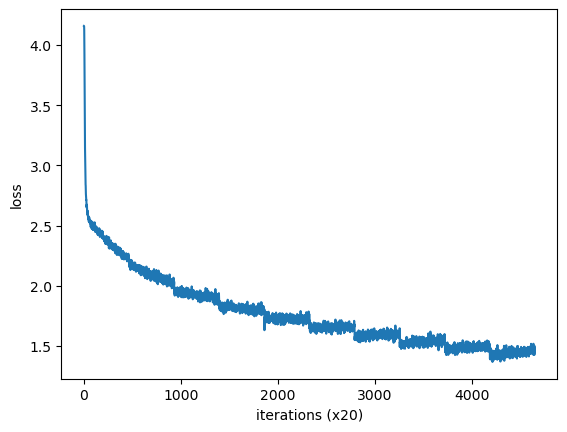

In [17]:
import pickle
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import create_contexts_target
from common.layers import SigmoidWithLoss
from dataset import ptb


window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)

model = CBOW(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

In [18]:
word_vecs = model.word_vecs
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)

In [19]:
from common.util import most_similar, analogy


pkl_file = 'cbow_params.pkl'

with open(pkl_file, 'rb') as f:
    params = pickle.load(f)
    word_vecs = params['word_vecs']
    word_to_id = params['word_to_id']
    id_to_word = params['id_to_word']

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] you
 we: 0.7431640625
 i: 0.71630859375
 someone: 0.6396484375
 they: 0.626953125
 your: 0.6171875

[query] year
 month: 0.865234375
 week: 0.7763671875
 summer: 0.76318359375
 spring: 0.73388671875
 decade: 0.69775390625

[query] car
 luxury: 0.5830078125
 auto: 0.58203125
 cars: 0.55126953125
 window: 0.55029296875
 truck: 0.5458984375

[query] toyota
 seita: 0.6591796875
 mazda: 0.642578125
 nissan: 0.63330078125
 weyerhaeuser: 0.626953125
 honda: 0.62548828125


In [20]:
analogy('king', 'man', 'queen',  word_to_id, id_to_word, word_vecs)
analogy('take', 'took', 'go',  word_to_id, id_to_word, word_vecs)
analogy('car', 'cars', 'child',  word_to_id, id_to_word, word_vecs)
analogy('good', 'better', 'bad',  word_to_id, id_to_word, word_vecs)


[analogy] king:man = queen:?
 woman: 5.3203125
 carolinas: 5.27734375
 cubans: 4.953125
 kid: 4.89453125
 toxin: 4.6796875

[analogy] take:took = go:?
 're: 4.6953125
 a.m: 4.63671875
 went: 4.35546875
 were: 4.26953125
 came: 4.1328125

[analogy] car:cars = child:?
 a.m: 7.23828125
 rape: 5.80078125
 daffynition: 5.4765625
 incest: 5.18359375
 children: 4.96484375

[analogy] good:better = bad:?
 more: 5.828125
 rather: 5.5390625
 less: 5.41796875
 greater: 4.4375
 worse: 4.1875


# 4.4 word2vec 남은 주제